In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal

import ipywidgets as widgets

from utils import *
from basis import *
from weighting import *

Unable to import ratio-db.py, perhaps due to a missing dependency. Using fallback code.


In [2]:

pixels = (500, 500)
ratio_xy_range = ((1,4),(1,4))
fundamental_xy = (100, 100)

data = np.zeros(pixels)


x_segment = (ratio_xy_range[0][0] * fundamental_xy[0], ratio_xy_range[0][1] * fundamental_xy[0])
x_range = (x_segment[1] - x_segment[0])
y_segment = (ratio_xy_range[1][0] * fundamental_xy[1], ratio_xy_range[1][1] * fundamental_xy[1])
y_range = (y_segment[1] - y_segment[0])

weights = data.copy()
diff_weights = data.copy()

max_weight = 0
max_diff_weight = 0

# for y in range(pixels[1]):

#     y_step = float(y) / pixels[1]
#     y_freq = y_segment[0] + y_range * y_step

#     for x in range(pixels[0]):

#         x_step = float(x) / pixels[0]
#         x_freq = x_segment[0] + x_range * x_step

#         if y_freq > x_freq:
#             (d, n) = (x_freq, y_freq)
#         else:
#             (d, n) = (y_freq, x_freq)

#         ratio = n / d
#         diff = n - d

#         dyad = approximate_ratio([ratio])
#         he_weight = he_decimal_approx([ratio])

#         if diff == 0:
#             diff_weight = 1
#         else:
#             t_dyad = approximate_ratio([d / diff])

#             triad_list = np.row_stack((t_dyad, dyad))
#             triad = utils.normalize_ratios(triad_list)
#             diff_weight = he_default(triad)

#         # weight = np.sqrt(he_weight * diff_weight)

#         weights[y, x] = he_weight
#         diff_weights[y, x] = diff_weight

#         if he_weight > max_weight:
#             max_weight = he_weight
#         if diff_weight > max_diff_weight:
#             max_diff_weight = diff_weight


he range: inf, inf
diff range: inf, inf


C:\Windows\Temp\ipykernel_18220\2962718251.py:1: RuntimeWarning: divide by zero encountered in log
  data_he = (8 - (np.log(weights) / (np.log(2)))) / 8
C:\Windows\Temp\ipykernel_18220\2962718251.py:2: RuntimeWarning: divide by zero encountered in log
  data_diff = (28 - (np.log(diff_weights)/ (np.log(2)))) / 28


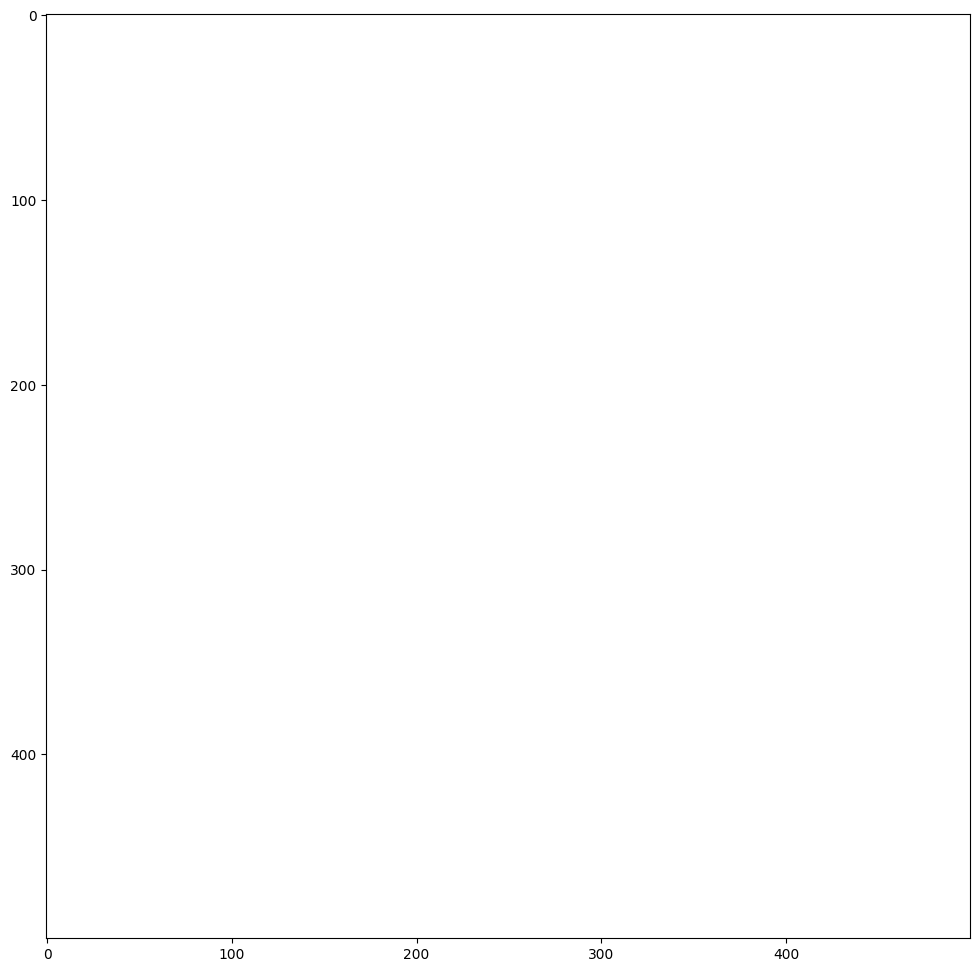

In [3]:
data_he = (8 - (np.log(weights) / (np.log(2)))) / 8
data_diff = (28 - (np.log(diff_weights)/ (np.log(2)))) / 28

print(f"he range: {data_he.min()}, {data_he.max()}")
print(f"diff range: {data_diff.min()}, {data_diff.max()}")

plt.figure(figsize=(12,12))
plt.imshow(data_he)
# plt.imshow(data_he * data_diff)
plt.show()

In [4]:
# continued fraction HE basis

start_harmonic = 1
end_harmonic = 8

start_cents=ratio_to_cents(start_harmonic)
end_cents=ratio_to_cents(end_harmonic)

cents_res = 1

cf_basis_cents = np.arange(start_cents, end_cents, step=cents_res)
cf_basis_length = cf_basis_cents.shape[0]

cf_basis_decimals = np.vectorize(cents_to_ratio)(cf_basis_cents)
cf_basis_cf = [ np.asarray(get_cf(d)) for d in cf_basis_decimals ]
cf_basis_ratios = np.asarray([ approximate_ratio([d])[0] for d in cf_basis_decimals ])


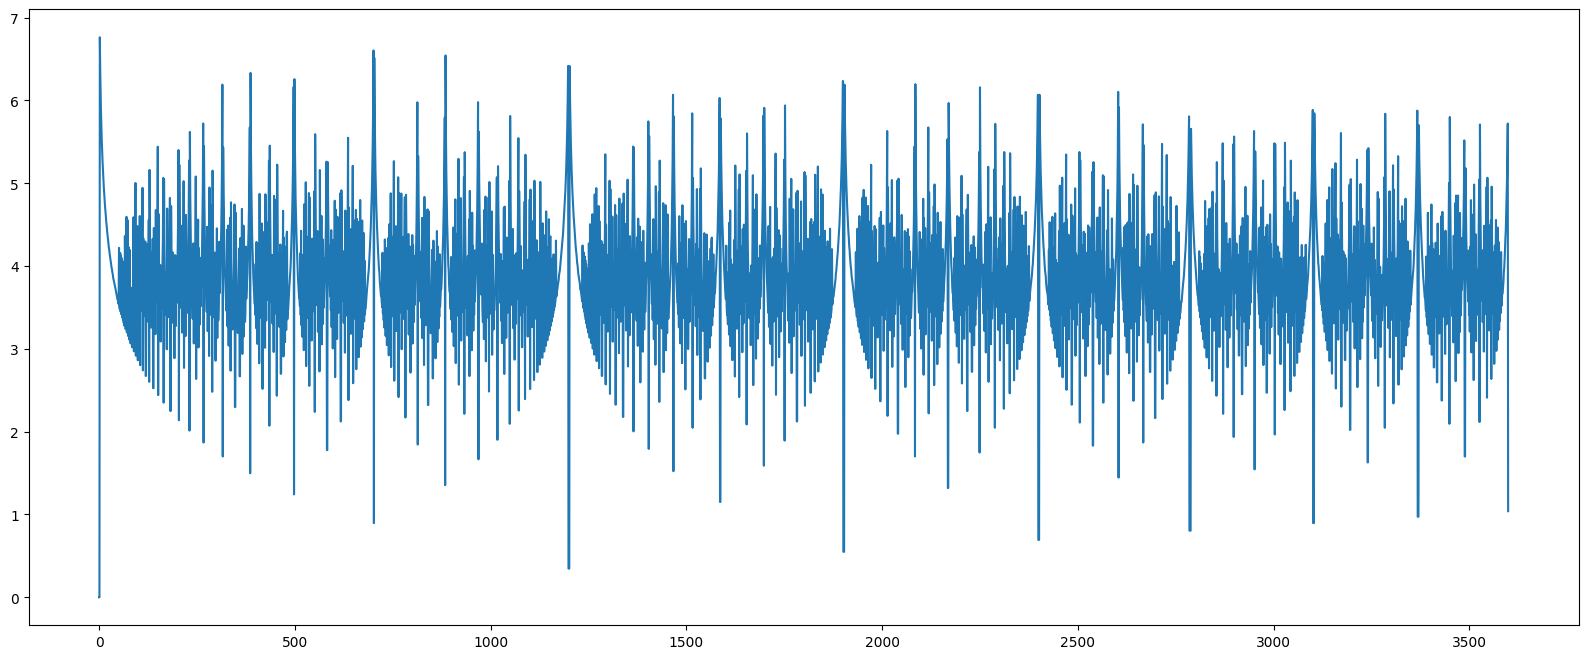

In [5]:
# do_cf_weighing = np.vectorize(he_default)
cf_basis_weights = np.apply_along_axis(he_default, 1, cf_basis_ratios)

cf_he_data = np.log(cf_basis_weights)
# cf_he_data = cf_basis_weights

plt.figure(figsize=(20,8))
plt.plot(cf_he_data)
# print()

In [6]:
scroll_default=(680,720)

scroll = widgets.FloatRangeSlider(value=scroll_default, min=0.0, max=end_cents, step=cents_res, description="CFHE scroll")
point = widgets.IntSlider(value=700, min=scroll_default[0], max=scroll_default[1], description="cents")

def get_cf_slope(cf):
    max_index = list(cf).index(cf.max())
    if max_index == 0:
        return 0

    return (cf[max_index] - cf[0]) / max_index

@widgets.interact(scroll=scroll, point=point)
def update_scroll_display(**kwArgs):
    scroll_index = kwArgs["scroll"]
    # print(scroll_index)
    # window = cf_he_data[int(round(params[0])):int(round(params[1]))]

    figure, axes = plt.subplots(2, 1)
    # plt.figure(figsize=(20,4))
    figure.set_size_inches(20, 8)

    point_x = int(kwArgs["point"])

    axes[0].plot(cf_he_data)
    axes[0].plot(point_x, cf_he_data[point_x], 'x')
    axes[0].set_xlim(scroll_index)

    cf = np.asarray(get_cf(cents_to_ratio(point_x)))
    axes[1].plot(cf)
    
    cf_range = cf.max() - cf.min()
    cf_avg = np.sum(cf) / float(cf.size)
    cf_slope = get_cf_slope(cf)

    cf_max = list(cf).index(cf.max())
    cf_axis = np.arange(cf_max+1)
    axes[1].plot(cf_axis, cf_axis * cf_slope)

    print(f'cf_range: {cf_range}')
    print(f'cf_avg: {cf_avg}')
    print(f'cf_slope: {cf_slope}')
    # for i in np.arange(int(params[0]), int(params[1])):
    #     print(f'{cf_basis_decimals[i]}:\t{cf_basis_cf[i]}')


interactive(children=(FloatRangeSlider(value=(680.0, 720.0), description='CFHE scroll', max=3600.0, step=1.0),…

In [7]:
# cf slope he

slope_window = 3600

# scroll_default=(680,720)

ctrl_scroll_x = widgets.FloatSlider(value=0, min=0.0, max=slope_window, step=cents_res, description="scroll")
ctrl_window_size = widgets.FloatSlider(value=1200, min=0.0, max=slope_window, step=cents_res, description="zoom")
ctrl_point = widgets.IntSlider(value=700, min=0, max=slope_window, description="cents")

cf_slope_weights = np.asarray([get_cf_slope(cf) for cf in cf_basis_cf[:slope_window]])
# cf_slope_rads = ((np.arctan(cf_slope_weights) * np.pi / 180.0) - np.pi / 4)**2
cf_slope_rads = (np.arctan(cf_slope_weights) * np.pi / 180.0)

# cf_slope_he_data = cf_slope_weights
# cf_slope_he_data = np.sqrt(cf_slope_weights)

cf_slope_he_data = cf_slope_weights
cf_rad_he_data = cf_slope_rads
# cf_slope_he_data = np.log(np.sqrt(cf_slope_weights))
# cf_rad_he_data = (-np.log(cf_slope_rads) * 2) ** 10

@widgets.interact(scroll=ctrl_scroll_x, window=ctrl_window_size, point=ctrl_point)
def update_scroll_display(**kwArgs):
    scroll_x = kwArgs["scroll"]
    window_size = kwArgs["window"]

    figure, axes = plt.subplots(2, 1)
    figure.set_size_inches(20, 8)

    point_x = int(kwArgs["point"])

    axes[0].plot(cf_slope_he_data)
    axes[0].plot(point_x, cf_slope_he_data[point_x], 'x')

    axes[1].plot(cf_rad_he_data)
    axes[1].plot(point_x, cf_rad_he_data[point_x], 'x')

    print(f'point {point_x}: {cf_slope_he_data[point_x]} {cf_rad_he_data[point_x]}')

    axes[0].set_xlim(scroll_x, scroll_x + window_size)
    axes[1].set_xlim(scroll_x, scroll_x + window_size)



interactive(children=(FloatSlider(value=0.0, description='scroll', max=3600.0, step=1.0), FloatSlider(value=12…

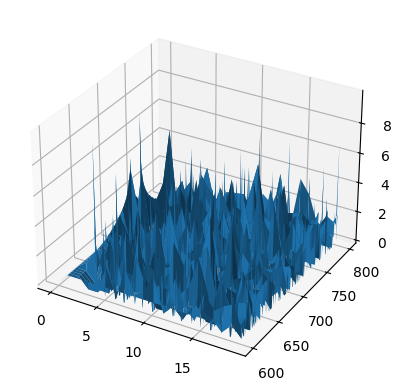

In [ ]:
# cf surface

max_cf_depth = 20

cf_surf_cents_range = (600, 800)
# cf_surf_x_range = cf_surf_x_cents_range[1] - cf_surf_x_cents_range[0]
cf_surf_y_axis = np.arange(*cf_surf_cents_range)
cf_surf_num_rows = len(cf_surf_y_axis)

cf_surf_decimals = [ cents_to_ratio(c) for c in cf_surf_y_axis ]
cf_surf_cfs = [ np.asarray(get_cf(d, max_cf_depth)) for d in cf_surf_decimals ]

X = np.arange(max_cf_depth)
# Y = np.arange(cf_surf_num_rows)
Z = np.zeros((cf_surf_num_rows, max_cf_depth))

for i in range(cf_surf_num_rows):
    cf = cf_surf_cfs[i]
    l = len(cf)
    Z[i, :l] += cf

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

Xm,Ym = np.meshgrid(X, cf_surf_y_axis)
ax.plot_surface(Xm, Ym, np.log(Z))
